In [1]:
import torch
from torch import nn
import numpy as np
import transformers

In [2]:
import torch
from transformers import GPT2LMHeadModel, AutoTokenizer, GPT2Config
dir = '/mntcephfs/data/ruoyusun/common_dirs/gpt2-small'
model = GPT2LMHeadModel.from_pretrained(dir)
tokenizer = AutoTokenizer.from_pretrained(dir)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
'''测试抹除第一个token的语义信息'''
word_embedding = model.transformer.wte.weight
with torch.no_grad():
    word_embedding = torch.cat((word_embedding,torch.zeros_like(word_embedding[0],requires_grad=True).reshape(1,-1)),dim=0)
model.transformer.wte.weight = torch.nn.Parameter(word_embedding)
'''测试抹除第一个token的位置信息'''
# pe_embedding = model.transformer.wpe.weight
# with torch.no_grad():
#     pe_embedding[0] = torch.zeros_like(pe_embedding[0], requires_grad = True)
model.eval()

/mntcephfs/lab_data/hanyizhou/anaconda/pe/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/mntcephfs/lab_data/hanyizhou/anaconda/pe/lib/python3.11/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969073/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


Embedding(50257, 768)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [13]:
'''给token前面加上空白信息'''
inputs_pad = tokenizer(tokenizer.pad_token+" decision left CNN Chief Medical Correspondent Sanjay Gupta as the only doctor at the hospital to get the patients through the night.", return_tensors="pt")
'''两段话拼在一起的token'''
#inputs = tokenizer("The decision left CNN Chief Medical Correspondent Sanjay Gupta as the only doctor at the hospital to get the patients through the night. Democratic front-runner Hillary Clinton was ahead by a slim margin in Missouri on Wednesday, but the race remained in limbo pending word on whether rival Sen. Bernie Sanders of Vermont would seek a recount.", return_tensors="pt")
'''单一句话的token'''
inputs = tokenizer("The decision left CNN Chief Medical Correspondent Sanjay Gupta as the only doctor at the hospital to get the patients through the night.", return_tensors="pt")
outputs_pad = model(**inputs_pad, labels=inputs_pad["input_ids"], output_attentions = True)
outputs = model(**inputs, labels=inputs["input_ids"], output_attentions = True, output_hidden_states=True)
outputs.loss

tensor(3.3670, grad_fn=<NllLossBackward0>)

In [12]:
inputs_pad.input_ids.shape, inputs.input_ids.shape

(torch.Size([1, 26]), torch.Size([1, 26]))

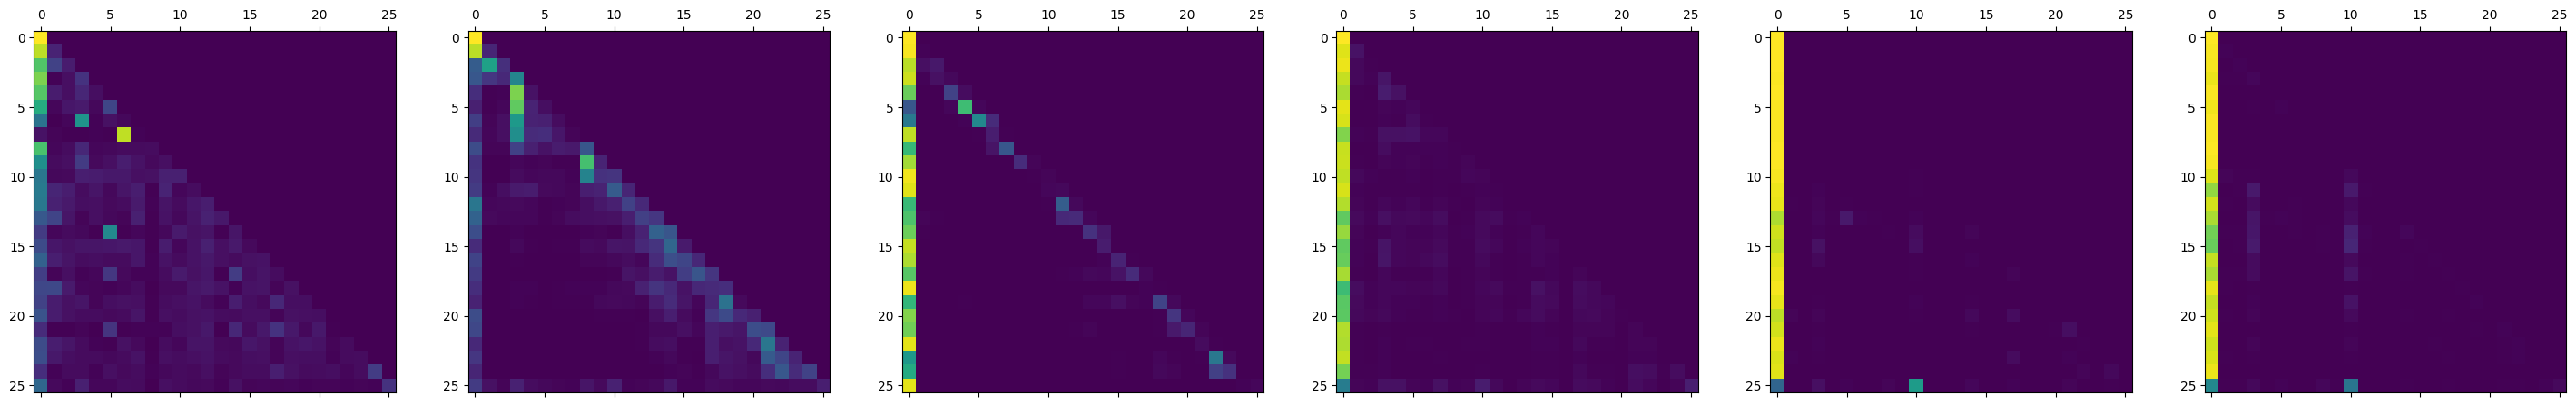

In [16]:
import numpy as np
from matplotlib import pyplot as plt
attention = [outputs.attentions[i][0].detach().cpu().numpy() for i in range(12)]
vmin = min([_attention.min() for _attention in attention])
vmax = max([_attention.max() for _attention in attention])
attention_pad = [outputs_pad.attentions[i][0].detach().cpu().numpy() for i in range(12)]
'''画全局图像'''
# for j in range(12):
#     fig,axes = plt.subplots(ncols=12,figsize = (48,4))
#     for i in range(12):
#         axes[i].matshow(attention[j][i],vmin=vmin, vmax=vmax)
    
'''画一个head的6个图'''
head = 6
fig,axes = plt.subplots(ncols = 6, figsize = (36,6))
for i in range(6):
    axes[i].matshow(attention[2*i+1][head])

#plt.savefig(f'./output/fig_without_semantic/fig_witout_semantic {j} layer')

In [17]:
data = inputs.input_ids
embedding_layer = model.transformer.wte
pos_layer = model.transformer.wpe
W_matrix = []
for i in range(12):
    W_matrix.append(model.transformer.h[i].attn.c_attn)
split_fun = model.transformer.h[0].attn._split_heads


# 查看第一层的位置编码和token embedding的关系



In [18]:
#weight的2304维是768*3的结果, 分别对应q, k, v
#W_matrix[0].weight.shape, W_matrix[0].bias.shape->(torch.Size([768, 2304]), torch.Size([2304]))
#得到的qkv再用split_fun分割就行, 为了更清楚地知道这些矩阵的特征, 我先把他们分割
wq, wk, wv = [],[],[]
for i in range(12):
    weight = W_matrix[i].weight.split(768, dim=-1)
    bias = W_matrix[i].bias.split(768)
    wq.append((weight[0],bias[0]))
    wk.append((weight[1],bias[1]))
    wv.append((weight[2],bias[2]))

layer_norm = model.transformer.h[0].ln_1


由于实际的计算过程中, 从 $x_i$ 变成 $q_i$ 的过程为: $q_i = W_q\cdot (x_i+p_i)+b_q$, 做一个变形: 
$$
q_i = W_q\cdot x_i+b_q+W_q\cdot p_i = (W_q\cdot x_i+b_q)+W_q\cdot p_i=\tilde{q_i}+\tilde{p_i}, 
$$
这样我们可以分别考察:
$\tilde{q_i}^T\cdot \tilde{k_j}, \quad\tilde{q_i}^T\cdot \tilde{p_j}+\tilde{p_i}\cdot \tilde{k_j},\quad \tilde{p_i}^T\cdot \tilde{p_j}$


In [98]:
#计算, 目前看的是第0个头
wte = embedding_layer(data)
wpe = pos_layer(torch.arange(data.shape[-1]).unsqueeze(0))

#分别对wte, wpe做layernorm, 但是这个layernorm很特殊
mu_wpe = (wpe).mean(-1, keepdim =True)
mu_wte = wte.mean(-1, keepdim = True)
mu = mu_wpe+mu_wte
var = (wte+wpe-mu).pow(2).mean(-1,keepdim=True)
gamma = layer_norm.weight
beta = layer_norm.bias
wte = (wte-mu_wte)*torch.rsqrt(var+1e-6)*gamma+beta
wpe = (wpe-mu_wpe)*torch.rsqrt(var+1e-6)*gamma+beta


query = split_fun(wte@wq[0][0]+wq[0][1],12,64)
key = split_fun(wte@wk[0][0]+wk[0][1],12,64)
pos_query = split_fun((wpe@wq[0][0]),12,64)
pos_key = split_fun((wpe@wk[0][0]),12,64)
attn_weights_qk = torch.matmul(query, key.transpose(-1, -2))
attn_weights_abs = (torch.matmul(query,pos_key.transpose(-1,-2))+torch.matmul(pos_query,key.transpose(-1,-2)))
attn_weights_relative = torch.matmul(pos_query,pos_key.transpose(-1,-2))
attn_weights = torch.abs(attn_weights_qk)+torch.abs(attn_weights_abs)+torch.abs(attn_weights_relative)


In [99]:
#模拟一下attention 函数
query_length, key_length = query.size(-2), key.size(-2)
max_positions = 1024
attn_bias = torch.tril(torch.ones((max_positions, max_positions), dtype=torch.bool)).view(
                1, 1, max_positions, max_positions
            )
causal_mask = attn_bias[:, :, key_length - query_length : key_length, :key_length]
mask_value = torch.finfo(attn_weights_qk.dtype).min
mask_value = torch.full([], mask_value, dtype=attn_weights_qk.dtype, device=attn_weights_qk.device)
attn_weights_qk = torch.where(causal_mask, attn_weights_qk.to(attn_weights_qk.dtype), mask_value)
attn_weights_abs = torch.where(causal_mask, attn_weights_abs.to(attn_weights_abs.dtype), mask_value)
attn_weights_relative = torch.where(causal_mask, attn_weights_relative.to(attn_weights_relative.dtype), mask_value)
attn_weights = torch.where(causal_mask, attn_weights.to(attn_weights.dtype), mask_value)

relative_part = torch.abs(attn_weights_relative)/attn_weights
semantic_part = torch.abs(attn_weights_qk)/attn_weights
abs_part = torch.abs(attn_weights_abs)/attn_weights

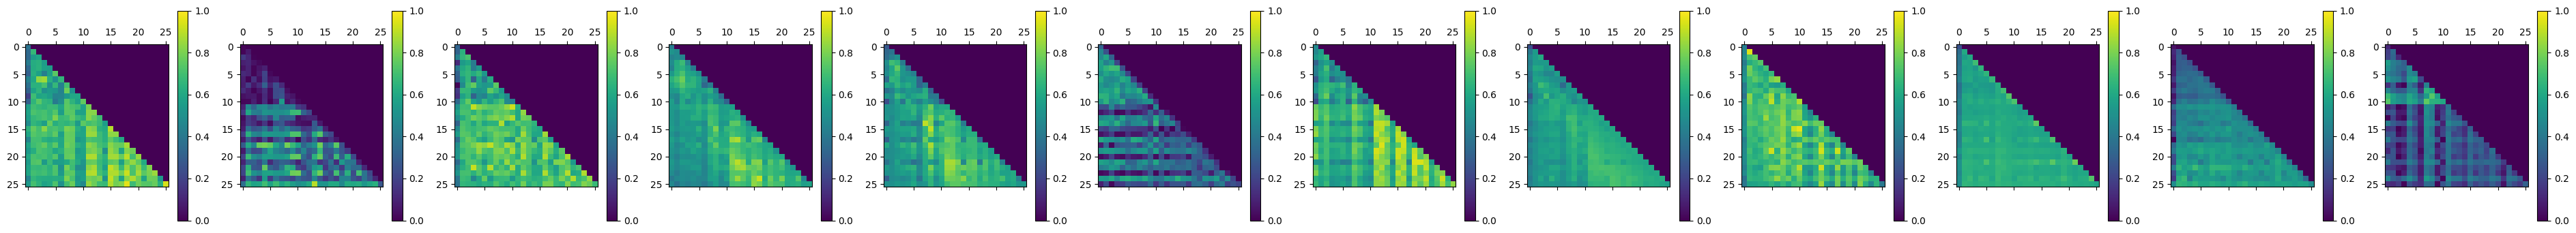

In [137]:
from matplotlib import pyplot as plt
part = [abs_part[0][i].detach().cpu().numpy() for i in range(12)]
# vmin = min([_part.min() for _part in part])
# vmax = max([_part.max() for _part in part])
fig, axes = plt.subplots(ncols=12, figsize=(48,4))
for i in range(12):
    im = axes[i].matshow(part[i],vmin=0,vmax=1)
    fig.colorbar(im,ax=axes[i])


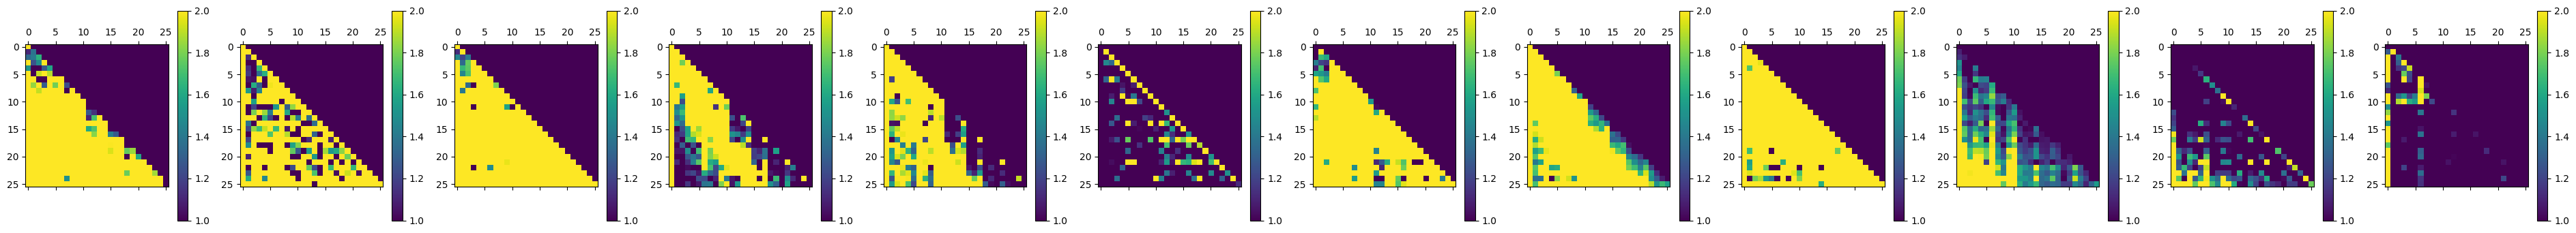

In [131]:
part = [(semantic_part[0][i]/relative_part[0][i]).detach().cpu().numpy() for i in range(12)]
#vmin = min([_part.min() for _part in part])
vmin = 1
#vmax = 100
fig, axes = plt.subplots(ncols=12, figsize=(48,4))
for i in range(12):
    im = axes[i].matshow(part[i],vmax =2,vmin = 1)
    fig.colorbar(im,ax=axes[i])

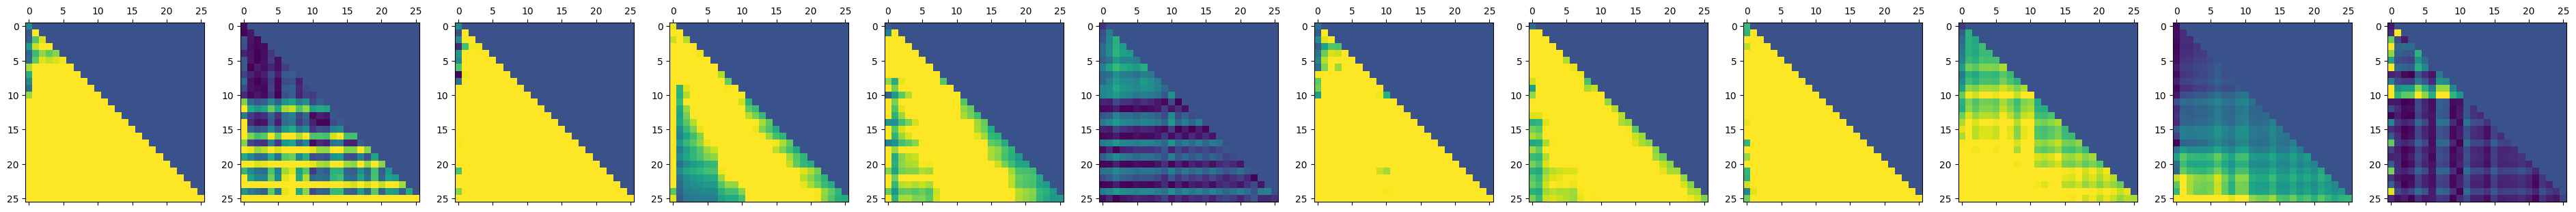

In [128]:
from matplotlib import pyplot as plt
part = [(abs_part[0][i]/relative_part[0][i]).detach().cpu().numpy() for i in range(12)]
#vmin = min([_part.min() for _part in part])
#vmax = max([_part.max() for _part in part])
#vmax = 100
vmin = 0
fig, axes = plt.subplots(ncols=12, figsize=(48,4))
for i in range(12):
    im = axes[i].matshow(part[i],vmax = 4
                         ,vmin=vmin)
#fig.colorbar(im)

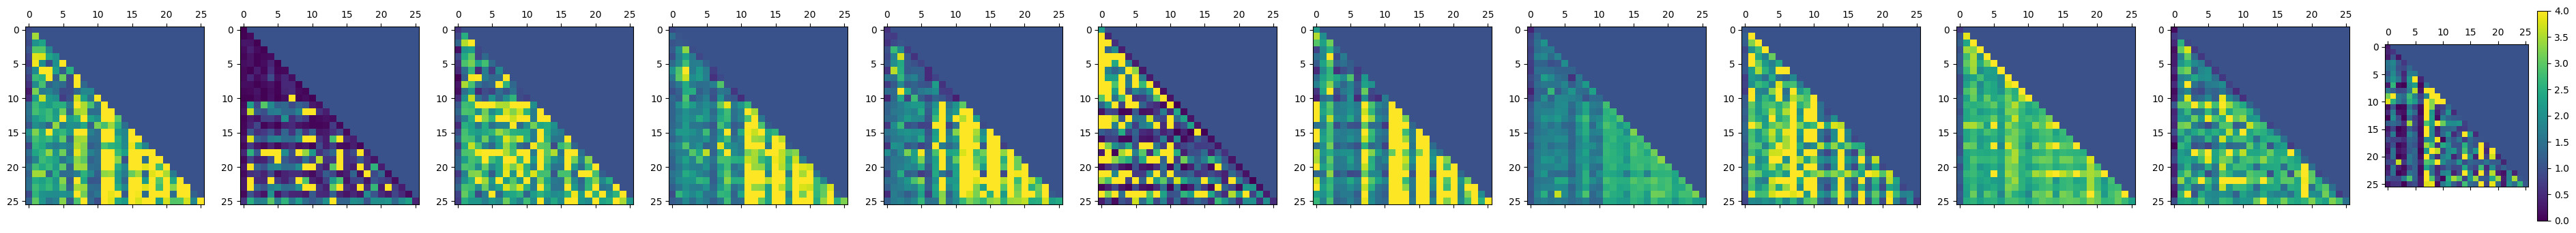

In [129]:
from matplotlib import pyplot as plt
part = [(abs_part[0][i]/semantic_part[0][i]).detach().cpu().numpy() for i in range(12)]
#vmin = min([_part.min() for _part in part])
#vmax = max([_part.max() for _part in part])

vmin = 0
fig, axes = plt.subplots(ncols=12, figsize=(48,4))
for i in range(12):
    im = axes[i].matshow(part[i],vmin=vmin,vmax = 4)
fig.colorbar(im)

In [53]:
part[4][12:16,12:16]

array([[4.639106 , 1.       , 1.       , 1.       ],
       [4.894436 , 2.2363713, 1.       , 1.       ],
       [9.580844 , 4.5044084, 0.9136011, 1.       ],
       [5.408069 , 3.4795847, 1.9359963, 4.149133 ]], dtype=float32)

In [12]:
#验证, 我的计算过程没什么太大的问题, 可以验证, attn_w和attn_weights只有计算精度误差
# wte = embedding_layer(data)
# wpe = pos_layer(torch.arange(data.shape[-1]).unsqueeze(0))
# wte = wte+wpe
# #q,k,v = W_matrix[0](wte).split(768,dim=-1)
# query = split_fun(wte@wq[0][0]+wq[0][1],12,64)
# # q = split_fun(q,12,64)
# # k = split_fun(k,12,64)
# key = split_fun(wte@wk[0][0]+wk[0][1],12,64)
# value = split_fun(wte@wv[0][0]+wv[0][1],12,64)
# attn_weights = torch.matmul(query, key.transpose(-1, -2))
# attn_w = torch.matmul(q,k.transpose(-1,-2))
# attn_weights = attn_weights / torch.full(
#                 [], query.size(-1) ** 0.5, dtype=attn_weights.dtype, device=attn_weights.device
#             )
# attn_w = attn_w/ torch.full(
#                 [], query.size(-1) ** 0.5, dtype=attn_weights.dtype, device=attn_weights.device
#             )


In [13]:
from typing import Optional, Tuple, Union
from transformers.pytorch_utils import Conv1D
class GPT2Attention(nn.Module):
    def __init__(self, config, is_cross_attention=False, layer_idx=None):
        super().__init__()

        max_positions = config.max_position_embeddings
        self.register_buffer(
            "bias",
            torch.tril(torch.ones((max_positions, max_positions), dtype=torch.bool)).view(
                1, 1, max_positions, max_positions
            ),
            persistent=False,
        )
        self.register_buffer("masked_bias", torch.tensor(-1e4), persistent=False)

        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.split_size = self.embed_dim
        if self.head_dim * self.num_heads != self.embed_dim:
            raise ValueError(
                f"`embed_dim` must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`:"
                f" {self.num_heads})."
            )

        self.scale_attn_weights = config.scale_attn_weights
        self.is_cross_attention = is_cross_attention

        # Layer-wise attention scaling, reordering, and upcasting
        self.scale_attn_by_inverse_layer_idx = config.scale_attn_by_inverse_layer_idx
        self.layer_idx = layer_idx
        self.reorder_and_upcast_attn = config.reorder_and_upcast_attn

        if self.is_cross_attention:
            self.c_attn = Conv1D(2 * self.embed_dim, self.embed_dim)
            self.q_attn = Conv1D(self.embed_dim, self.embed_dim)
        else:
            self.c_attn = Conv1D(3 * self.embed_dim, self.embed_dim)
        self.c_proj = Conv1D(self.embed_dim, self.embed_dim)

        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

        self.pruned_heads = set()


    def _attn(self, query, key, value, attention_mask=None, head_mask=None):
        attn_weights = torch.matmul(query, key.transpose(-1, -2))

        if self.scale_attn_weights:
            attn_weights = attn_weights / torch.full(
                [], value.size(-1) ** 0.5, dtype=attn_weights.dtype, device=attn_weights.device
            )

        # Layer-wise attention scaling
        if self.scale_attn_by_inverse_layer_idx:
            attn_weights = attn_weights / float(self.layer_idx + 1)

        if not self.is_cross_attention:
            # if only "normal" attention layer implements causal mask
            query_length, key_length = query.size(-2), key.size(-2)
            causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length]
            mask_value = torch.finfo(attn_weights.dtype).min
            # Need to be a tensor, otherwise we get error: `RuntimeError: expected scalar type float but found double`.
            # Need to be on the same device, otherwise `RuntimeError: ..., x and y to be on the same device`
            mask_value = torch.full([], mask_value, dtype=attn_weights.dtype, device=attn_weights.device)
            attn_weights = torch.where(causal_mask, attn_weights.to(attn_weights.dtype), mask_value)

        if attention_mask is not None:
            # Apply the attention mask
            attn_weights = attn_weights + attention_mask

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
        attn_weights = attn_weights.type(value.dtype)
        attn_weights = self.attn_dropout(attn_weights)

        # Mask heads if we want to
        if head_mask is not None:
            attn_weights = attn_weights * head_mask

        attn_output = torch.matmul(attn_weights, value)

        return attn_output, attn_weights

    def _upcast_and_reordered_attn(self, query, key, value, attention_mask=None, head_mask=None):
        # Use `torch.baddbmm` (a bit more efficient w/ alpha param for scaling -- from Megatron-LM)
        bsz, num_heads, q_seq_len, dk = query.size()
        _, _, k_seq_len, _ = key.size()

        # Preallocate attn_weights for `baddbmm`
        attn_weights = torch.empty(bsz * num_heads, q_seq_len, k_seq_len, dtype=torch.float32, device=query.device)

        # Compute Scale Factor
        scale_factor = 1.0
        if self.scale_attn_weights:
            scale_factor /= float(value.size(-1)) ** 0.5

        if self.scale_attn_by_inverse_layer_idx:
            scale_factor /= float(self.layer_idx + 1)

        # Upcast (turn off autocast) and reorder (Scale K by 1 / root(dk))
        with autocast(enabled=False):
            q, k = query.reshape(-1, q_seq_len, dk), key.transpose(-1, -2).reshape(-1, dk, k_seq_len)
            attn_weights = torch.baddbmm(attn_weights, q.float(), k.float(), beta=0, alpha=scale_factor)
            attn_weights = attn_weights.reshape(bsz, num_heads, q_seq_len, k_seq_len)

        if not self.is_cross_attention:
            # if only "normal" attention layer implements causal mask
            query_length, key_length = query.size(-2), key.size(-2)
            causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length]
            mask_value = torch.finfo(attn_weights.dtype).min
            # Need to be a tensor, otherwise we get error: `RuntimeError: expected scalar type float but found double`.
            # Need to be on the same device, otherwise `RuntimeError: ..., x and y to be on the same device`
            mask_value = torch.tensor(mask_value, dtype=attn_weights.dtype).to(attn_weights.device)
            attn_weights = torch.where(causal_mask, attn_weights, mask_value)

        if attention_mask is not None:
            # Apply the attention mask
            attn_weights = attn_weights + attention_mask

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op if otherwise
        if attn_weights.dtype != torch.float32:
            raise RuntimeError("Error with upcasting, attn_weights does not have dtype torch.float32")
        attn_weights = attn_weights.type(value.dtype)
        attn_weights = self.attn_dropout(attn_weights)

        # Mask heads if we want to
        if head_mask is not None:
            attn_weights = attn_weights * head_mask

        attn_output = torch.matmul(attn_weights, value)

        return attn_output, attn_weights

    def _split_heads(self, tensor, num_heads, attn_head_size):
        """
        Splits hidden_size dim into attn_head_size and num_heads
        """
        new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
        tensor = tensor.view(new_shape)
        return tensor.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    def _merge_heads(self, tensor, num_heads, attn_head_size):
        """
        Merges attn_head_size dim and num_attn_heads dim into hidden_size
        """
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attn_head_size,)
        return tensor.view(new_shape)

    def forward(
        self,
        hidden_states: Optional[Tuple[torch.FloatTensor]],
        layer_past: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = False,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[Union[torch.Tensor, Tuple[torch.Tensor]], ...]:
        if encoder_hidden_states is not None:
            if not hasattr(self, "q_attn"):
                raise ValueError(
                    "If class is used as cross attention, the weights `q_attn` have to be defined. "
                    "Please make sure to instantiate class with `GPT2Attention(..., is_cross_attention=True)`."
                )

            query = self.q_attn(hidden_states)
            key, value = self.c_attn(encoder_hidden_states).split(self.split_size, dim=2)
            attention_mask = encoder_attention_mask
        else:
            query, key, value = self.c_attn(hidden_states).split(self.split_size, dim=2)

        query = self._split_heads(query, self.num_heads, self.head_dim)
        key = self._split_heads(key, self.num_heads, self.head_dim)
        value = self._split_heads(value, self.num_heads, self.head_dim)

        if layer_past is not None:
            past_key, past_value = layer_past
            key = torch.cat((past_key, key), dim=-2)
            value = torch.cat((past_value, value), dim=-2)

        if use_cache is True:
            present = (key, value)
        else:
            present = None

        if self.reorder_and_upcast_attn:
            attn_output, attn_weights = self._upcast_and_reordered_attn(query, key, value, attention_mask, head_mask)
        else:
            attn_output, attn_weights = self._attn(query, key, value, attention_mask, head_mask)

        attn_output = self._merge_heads(attn_output, self.num_heads, self.head_dim)
        attn_output = self.c_proj(attn_output)
        attn_output = self.resid_dropout(attn_output)

        outputs = (attn_output, present)
        if output_attentions:
            outputs += (attn_weights,)

        return outputs  # a, present, (attentions)
config = GPT2Config()
attn_model = GPT2Attention(config)
std_model = model.transformer.h[0].attn
attn_model.c_attn.weight = std_model.c_attn.weight
attn_model.c_attn.bias = std_model.c_attn.bias
